# DSA4212 Assignment 1
**CAA 17 March 2023 18:10**

Reference: https://github.com/davidcpage/cifar10-fast

## Imports

In [1]:
import os

# Suppress warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import cv2 as cv
from random import sample
import random
from collections import defaultdict
import pandas as pd
from functools import singledispatch, partial
from pydot import Dot, Cluster, Node, Edge

import torch
from torch import nn
from itertools import count, chain

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from IPython.core.display import display, Image

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive

    !nvidia-smi -L
    !lscpu |grep 'Model name'
    !free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-db162521-672f-45e7-0f35-a3082f2a0c23)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
12G


## Load Data

In [3]:
if 'google.colab' in str(get_ipython()):
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/dataset/DSA4212/assignment_1/

class_names = ["fish", "dog", "device", "chainsaw", "church",
               "horn", "truck", "petrol", "golf", "parachute"]

data_train = np.load('assignment_1_train.npz')
data_test = np.load('assignment_1_test.npz')

# set pixel intensities to [0,1]
X_train = data_train["img"].astype(np.float32) / 255.
X_test = data_test["img"].astype(np.float32) / 255.
Y_train = to_categorical(data_train["label"].astype(int))
Y_test = to_categorical(data_test["label"].astype(int))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [4]:
X_train.shape, Y_train.shape

((9296, 128, 128, 3), (9296, 10))

In [5]:
X_test.shape, Y_test.shape

((3856, 128, 128, 3), (3856, 10))

## Utilities

### Dictionary-related

In [6]:
def union(*dicts):
    return {k: v for d in dicts for (k, v) in d.items()}

def path_iter(nested_dict, pfx=()):
    for name, val in nested_dict.items():
        if isinstance(val, dict): yield from path_iter(val, (*pfx, name))
        else: yield ((*pfx, name), val)  

def map_nested(func, nested_dict):
    return {k: map_nested(func, v) if isinstance(v, dict) else func(v) for k,v in nested_dict.items()}

def group_by_key(items):
    res = defaultdict(list)
    for k, v in items: res[k].append(v) 
    return res

### Timer

In [7]:
class Timer:
    def __init__(self, synch=None):
        self.synch = synch or (lambda: None)
        self.synch()
        self.times = [time.perf_counter()]
        self.total_time = 0.0

    def __call__(self, include_in_total=True):
        self.synch()
        self.times.append(time.perf_counter())
        delta_t = self.times[-1] - self.times[-2]
        if include_in_total:
            self.total_time += delta_t
        return delta_t

def localtime():
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

### Logging Table

In [8]:
default_table_formats = {float: '{:{w}.4f}', str: '{:>{w}s}', 'default': '{:{w}}', 'title': '{:>{w}s}'}

def table_formatter(val, is_title=False, col_width=12, formats=None):
    formats = formats or default_table_formats
    type_ = lambda val: float if isinstance(val, (float, np.float)) else type(val)
    return (formats['title'] if is_title else formats.get(type_(val), formats['default'])).format(val, w=col_width)

def every(n, col):
    return lambda data: data[col] % n == 0

class Table:
    def __init__(self, keys=None, report=(lambda data: True), formatter=table_formatter):
        self.keys, self.report, self.formatter = keys, report, formatter
        self.log = []
        
    def append(self, data):
        self.log.append(data)
        data = {' '.join(p): v for p,v in path_iter(data)}
        self.keys = self.keys or data.keys()
        if len(self.log) == 1:
            print(*(self.formatter(k, True) for k in self.keys))
        if self.report(data):
            print(*(self.formatter(data[k]) for k in self.keys))
            
    def df(self):
        return pd.DataFrame([{'_'.join(p): v for p,v in path_iter(row)} for row in self.log])  

### Data Preprocessing

In [9]:
def preprocess2(dataset, transforms):
    dataset = copy.copy(dataset) # shallow copy
    for transform in transforms:
        dataset['data'] = transform(dataset['data'])
    return dataset

@singledispatch
def normalise(x, mean, std):
    return (x - mean) / std

@normalise.register(np.ndarray) 
def _(x, mean, std): 
    x = np.array(x, np.float32)
    x -= mean
    x *= 1.0/std
    return x

def unnormalise(x, mean, std):
    return x*std + mean

@singledispatch
def pad(x, border):
    raise NotImplementedError

@pad.register(np.ndarray)
def _(x, border):
    return np.pad(x, [(0, 0), (border, border), (border, border), (0, 0)], mode='reflect')

@singledispatch
def transpose(x, source, target):
    raise NotImplementedError

@transpose.register(np.ndarray)
def _(x, source, target):
    return x.transpose([source.index(d) for d in target]) 

### Data Augmentation

In [10]:
class Crop:
    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, x, x0, y0):
        return x[..., y0:y0+self.h, x0:x0+self.w]

    def options(self, shape):
        *_, H, W = shape
        return [{'x0': x0, 'y0': y0} for x0 in range(W+1-self.w) for y0 in range(H+1-self.h)]

    def output_shape(self, shape):
        *_, H, W = shape
        return (*_, self.h, self.w)

@singledispatch
def flip_lr(x):
    raise NotImplementedError

@flip_lr.register(np.ndarray)
def _(x): 
    return x[..., ::-1].copy()

class FlipLR:
    def __call__(self, x, choice):
        return flip_lr(x) if choice else x 

    def options(self, shape):
        return [{'choice': b} for b in [True, False]]

class Cutout:
    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, x, x0, y0):
        x[..., y0:y0+self.h, x0:x0+self.w] = 0.0
        return x

    def options(self, shape):
        *_, H, W = shape
        return [{'x0': x0, 'y0': y0} for x0 in range(W+1-self.w) for y0 in range(H+1-self.h)]    

class Transform():
    def __init__(self, dataset, transforms):
        self.dataset, self.transforms = dataset, transforms
        self.choices = None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, labels = self.dataset[index]
        data = data.copy()
        for choices, f in zip(self.choices, self.transforms):
            data = f(data, **choices[index])
        return data, labels

    def set_random_choices(self):
        self.choices = []
        x_shape = self.dataset[0][0].shape
        N = len(self)
        for t in self.transforms:
            self.choices.append(np.random.choice(t.options(x_shape), N))
            x_shape = t.output_shape(x_shape) if hasattr(t, 'output_shape') else x_shape

### Graph Building
In case we need a plot of the neural network
Works best with SVG on local, doesn't do well on Colab...

In [11]:
sep = '/'

def split(path):
    i = path.rfind(sep) + 1
    return path[:i].rstrip(sep), path[i:]

def normpath(path):
    parts = []
    for p in path.split(sep):
        if p == '..': parts.pop()
        elif p.startswith(sep): parts = [p]
        else: parts.append(p)
    return sep.join(parts)

def has_inputs(node):
    return type(node) == tuple

def pipeline(net):
    return [(sep.join(path), (node if has_inputs(node) else (node, [-1]))) for (path, node) in path_iter(net)]

def build_graph(net):
    flattened = pipeline(net)
    resolve_input = lambda rel_path, path, idx: normpath(sep.join((path, '..', rel_path))) if isinstance(rel_path, str) else flattened[idx+rel_path][0]
    return {path: (node[0], [resolve_input(rel_path, path, idx) for rel_path in node[1]]) for idx, (path, node) in enumerate(flattened)}

class ColorMap(dict):
    palette = ['#'+x for x in (
        'bebada,ffffb3,fb8072,8dd3c7,80b1d3,fdb462,b3de69,fccde5,bc80bd,ccebc5,ffed6f,1f78b4,33a02c,e31a1c,ff7f00,'
        '4dddf8,e66493,b07b87,4e90e3,dea05e,d0c281,f0e189,e9e8b1,e0eb71,bbd2a4,6ed641,57eb9c,3ca4d4,92d5e7,b15928'
    ).split(',')]

    def __missing__(self, key):
        self[key] = self.palette[len(self) % len(self.palette)]
        return self[key]

    def _repr_html_(self):
        css = (
        '.pill {'
            'margin:2px; border-width:1px; border-radius:9px; border-style:solid;'
            'display:inline-block; width:100px; height:15px; line-height:15px;'
        '}'
        '.pill_text {'
            'width:90%; margin:auto; font-size:9px; text-align:center; overflow:hidden;'
        '}'
        )
        s = '<div class=pill style="background-color:{}"><div class=pill_text>{}</div></div>'
        return '<style>'+css+'</style>'+''.join((s.format(color, text) for text, color in self.items()))

def make_dot_graph(nodes, edges, direction='LR', **kwargs):
    class Subgraphs(dict):
        def __missing__(self, path):
            parent, label = split(path)
            subgraph = Cluster(path, label=label, style='rounded, filled', fillcolor='#77777744')
            self[parent].add_subgraph(subgraph)
            return subgraph
    g = Dot(rankdir=direction, directed=True, **kwargs)
    g.set_node_defaults(
        shape='box', style='rounded, filled', fillcolor='#ffffff')
    subgraphs = Subgraphs({'': g})
    for path, attr in nodes:
        parent, label = split(path)
        subgraphs[parent].add_node(
            Node(name=path, label=label, **attr))
    for src, dst, attr in edges:
        g.add_edge(Edge(src, dst, **attr))
    return g

class DotGraph():
    def __init__(self, graph, size=15, direction='LR'):
        self.nodes = [(k, v) for k, (v,_) in graph.items()]
        self.edges = [(src, dst, {}) for dst, (_, inputs) in graph.items() for src in inputs]
        self.size, self.direction = size, direction

    def dot_graph(self, **kwargs):
        return make_dot_graph(self.nodes, self.edges, size=self.size, direction=self.direction,  **kwargs)

    #def _repr_svg_(self, **kwargs):
        #return self.dot_graph(**kwargs).create(format='svg').decode('utf-8')

    def _repr_png_(self, **kwargs):
        return self.dot_graph(**kwargs).create(format='png')

# DFS-like
def walk(dct, key):
    return walk(dct, dct[key]) if key in dct else key

def remove_by_type(net, node_type):  
    graph = build_graph(net)
    remap = {k: i[0] for k,(v,i) in graph.items() if isinstance(v, node_type)}
    return {k: (v, [walk(remap, x) for x in i]) for k, (v,i) in graph.items() if not isinstance(v, node_type)}

colors = ColorMap()
def draw(graph):
    return display(DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}))

### Training-related
Related to learning rate scheduler

In [12]:
@singledispatch
def cat(*xs):
    raise NotImplementedError

@singledispatch
def to_numpy(x):
    raise NotImplementedError

class PiecewiseLinear:
    def __init__(self, knots, vals):
        self.knots, self.vals = knots, vals
        plt.figure(figsize=(4,3))
        plt.plot(knots, vals)
        plt.title('Learning rate graph')
        plt.show()

    def __call__(self, t):
        return np.interp([t], self.knots, self.vals)[0]

class Const:
    def __init__(self, val):
        self.val = val

    def __call__(self, x):
        return self.val

### PyTorch-related

#### Basic

In [13]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

@cat.register(torch.Tensor)
def _(*xs):
    return torch.cat(xs)

@to_numpy.register(torch.Tensor)
def _(x):
    return x.detach().cpu().numpy()  

@pad.register(torch.Tensor)
def _(x, border):
    return nn.ReflectionPad2d(border)(x)

@transpose.register(torch.Tensor)
def _(x, source, target):
    return x.permute([source.index(d) for d in target]) 

def to(*args, **kwargs): 
    return lambda x: x.to(*args, **kwargs)

@flip_lr.register(torch.Tensor)
def _(x):
    return torch.flip(x, [-1])

#### Data Loading

In [14]:
class DataLoader():
    def __init__(self, dataset, batch_size, shuffle, set_random_choices=False, num_workers=0, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.set_random_choices = set_random_choices
        self.dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle, drop_last=drop_last
        )
    
    def __iter__(self):
        if self.set_random_choices:
            self.dataset.set_random_choices() 
        return ({'input': x.to(device).half(), 'target': y.to(device).long()} for (x,y) in self.dataloader)
    
    def __len__(self): 
        return len(self.dataloader)

#### NN Layers

In [15]:
class Network(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.graph = build_graph(net)
        for path, (val, _) in self.graph.items(): 
            setattr(self, path.replace('/', '_'), val)

    def nodes(self):
        return (node for node, _ in self.graph.values())

    def forward(self, inputs):
        outputs = dict(inputs)
        for k, (node, ins) in self.graph.items():
            if k not in outputs: 
                outputs[k] = node(*[outputs[x] for x in ins])
        return outputs

    # Set to half precision
    def half(self):
        for node in self.nodes():
            if isinstance(node, nn.Module) and not isinstance(node, nn.BatchNorm2d):
                node.half()
        return self

class Identity:
    def __call__(self, x): return x

class Add:
    def __call__(self, x, y): return x + y 
    
class AddWeighted:
    def __init__(self, wx, wy): self.wx, self.wy = wx, wy
    def __call__(self, x, y): return self.wx*x + self.wy*y 

class Mul(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight
    def __call__(self, x): 
        return x*self.weight

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

class Concat(nn.Module):
    def forward(self, *xs): return torch.cat(xs, 1)

#### Loss Metrics

In [16]:
# Losses
class CrossEntropyLoss:
    def __call__(self, log_probs, target):
        return torch.nn.functional.nll_loss(log_probs, target, reduction='none')

class Correct:
    def __call__(self, classifier, target):
        return classifier.max(dim = 1)[1] == target

x_ent_loss = Network({
    'loss':  (nn.CrossEntropyLoss(reduction='none'), ['logits', 'target']),
    'acc': (Correct(), ['logits', 'target'])
    # since Correct() looks at the highest value, there's no need to convert to probability
    # and thus softmax is not needed
})

#### Optimizers

In [17]:
def nesterov_update(w, dw, v, lr, weight_decay, momentum):
    dw.add_(weight_decay, w).mul_(-lr)
    v.mul_(momentum).add_(dw)
    w.add_(dw.add_(momentum, v))

def zeros_like(weights):
    return [torch.zeros_like(w) for w in weights]

def optimiser(weights, param_schedule, update, state_init):
    weights = list(weights)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': 0, 'weights': weights,  'opt_state': state_init(weights)}

def opt_step(update, param_schedule, step_number, weights, opt_state):
    step_number += 1
    param_values = {k: f(step_number) for k, f in param_schedule.items()}
    for w, v in zip(weights, opt_state):
        if w.requires_grad: update(w.data, w.grad.data, v, **param_values)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': step_number, 'weights': weights,  'opt_state': opt_state}

SGD = partial(optimiser, update=nesterov_update, state_init=zeros_like)

#### Training

In [18]:
def trainable_params(model):
    return {k:p for k,p in model.named_parameters() if p.requires_grad}

def reduce(batches, state, steps):
    for batch in chain(batches, [None]): 
        for step in steps:
            updates = step(batch, state)
            if updates:
                for k,v in updates.items(): state[k] = v
    return state

# define keys in the state dict as constants
MODEL = 'model'
LOSS = 'loss'
OUTPUT = 'output'
OPTS = 'optimisers'
ACT_LOG = 'activation_log'
WEIGHT_LOG = 'weight_log'

# step definitions
def forward(training_mode):
    def step(batch, state):
        if not batch: return
        model = state[MODEL]
        model.train(training_mode) # sets training mode to training_mode
        return {OUTPUT: state[LOSS](model(batch))}
    return step

def backward(dtype=None):
    def step(batch, state):
        state[MODEL].zero_grad()
        if not batch: return
        loss = state[OUTPUT][LOSS]
        if dtype is not None: loss = loss.to(dtype)
        loss.sum().backward()
    return step

def opt_steps(batch, state):
    if not batch: return
    return {OPTS: [opt_step(**opt) for opt in state[OPTS]]}

def log_activations(node_names=('loss', 'acc')):
    def step(batch, state):
        if '_tmp_logs_' not in state:
            state['_tmp_logs_'] = []
        if batch:
            state['_tmp_logs_'].extend((k, state[OUTPUT][k].detach()) for k in node_names)
        else:
            res = {k: to_numpy(torch.cat(xs)).astype(np.float) for k, xs in group_by_key(state['_tmp_logs_']).items()}
            del state['_tmp_logs_']
            return {ACT_LOG: res}
    return step

def epoch_stats(state):
    return {k: np.mean(v) for k, v in state[ACT_LOG].items()}

default_train_steps = (forward(training_mode=True), log_activations(('loss', 'acc')), backward(), opt_steps)
default_valid_steps = (forward(training_mode=False), log_activations(('loss', 'acc')))

def train_epoch(state, timer, train_batches, valid_batches, train_steps=default_train_steps, valid_steps=default_valid_steps):
    train_summary, train_time = epoch_stats(reduce(train_batches, state, train_steps)), timer()
    valid_summary, valid_time = epoch_stats(reduce(valid_batches, state, valid_steps)), timer(include_in_total=False) # DAWNBench rules
    return {
        'train': union({'time': train_time}, train_summary), 
        'valid': union({'time': valid_time}, valid_summary), 
        'total time': timer.total_time
    }

### Essential for preprocessing
- `shuffle(X, Y, seed)`
- `resize(X, image_size)`
- `augment(X, Y, augment_limit, datagen)`
- `sanity_check(datagen, t=4)`

In [19]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

def shuffle(X, Y, seed):
  set_seed(seed)
  indices_shuffled = np.arange(len(X))
  np.random.shuffle(indices_shuffled)
  return X[indices_shuffled], Y[indices_shuffled]

def resize(X, image_size):
  X_resized = []
  for i in X: X_resized.append(cv.resize(i, (image_size, image_size), interpolation=cv.INTER_AREA))
  return np.array(X_resized)

def augment(X, Y, augment_limit, datagen):
  datagen.fit(X)
  for X2, Y2 in datagen.flow(X, Y, batch_size=512):
    X = np.concatenate([X, X2])
    Y = np.concatenate([Y, Y2])
    if Y.shape[0] > augment_limit: break
  return X, Y

def sanity_check(datagen, t=4):
  datagen.fit(X_train)
  plt.figure(figsize=(10*2,(t+1)*2))
  for i, k in enumerate(sample(range(9296), 10)):
    plt.subplot(t+1,10,i+1)
    plt.axis("off")
    plt.imshow(X_train[k])
    plt.title(class_names[np.where(Y_train[k] == 1)[0][0]])
    aug = datagen.flow(X_train[k:k+1], batch_size=4)
    for m in range(t):
      plt.subplot(t+1,10,i+11+10*m)
      plt.axis("off")
      plt.imshow(next(aug)[0].astype('float32'))
      plt.title(class_names[np.where(Y_train[k] == 1)[0][0]])

## Preprocess loaded data
Divided into two stages
1. Resize, augment, shuffle
2. Split, normalize, transpose

### Data augmentation

In [20]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,      
    zoom_range=0.05,
    channel_shift_range=0.2
)

### Preprocessing stage 1

In [21]:
def preprocess1(X, Y, seed=4212, do_resize=True, do_augment=True, do_shuffle=True):
    if do_resize:
        X = resize(X, 32)
    set_seed(seed)
    if do_augment:
        X, Y = augment(X, Y, 12000, datagen)
    if do_shuffle:
        X, Y = shuffle(X, Y, seed)
    return X, Y

(12368, 32, 32, 3) (12368, 10)
(3856, 32, 32, 3) (3856, 10)


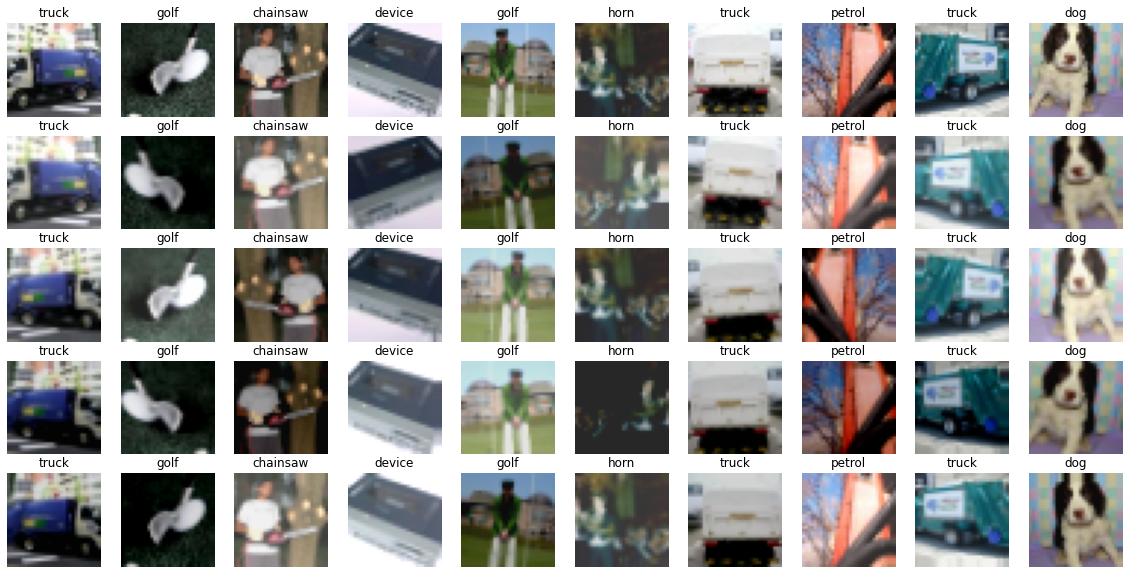

In [22]:
X_train, Y_train = preprocess1(X_train, Y_train)
print(X_train.shape, Y_train.shape)
X_test, Y_test = preprocess1(X_test, Y_test, do_augment=False, do_shuffle=False)
print(X_test.shape, Y_test.shape)

set_seed(4212)
sanity_check(datagen)

### Preprocessing stage 2

In [23]:
train_val_split = 0.8
n_train = int(train_val_split*len(X_train))
X_train, X_val, Y_train, Y_val = X_train[:n_train], X_train[n_train:], Y_train[:n_train], Y_train[n_train:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

dataset = {
    'train': {'data': X_train, 'targets': np.where(Y_train == 1)[1]},
    'valid': {'data': X_val, 'targets': np.where(Y_val == 1)[1]},
    'test': {'data': X_test, 'targets': np.where(Y_test == 1)[1]}
}

# partial allows one to call the functions with more keyword arguments later on
# e.g. partial(f, **kw1)(**kw2) = f(**(kw1 | kw2))
transforms = [
    partial(normalise,
            mean=np.array(np.mean(dataset['train']['data'], axis=(0,1,2)), dtype=np.float32),
            std=np.array(np.std(dataset['train']['data'], axis=(0,1,2)), dtype=np.float32)),
    partial(transpose,
            source='NHWC',
            target='NCHW'),
]

(9894, 32, 32, 3) (9894, 10)
(2474, 32, 32, 3) (2474, 10)


In [24]:
# preprocess2 takes in the dataset and a bunch of Transform objects so it works differently than preprocess1
train_set = list(zip(*preprocess2(dataset['train'], [partial(pad, border=4)] + transforms).values()))
valid_set = list(zip(*preprocess2(dataset['valid'], transforms).values()))
test_set = list(zip(*preprocess2(dataset['test'], transforms).values()))

## Model

### Architecture

In [25]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight_freeze=False, bias_freeze=False):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.requires_grad = not weight_freeze
        self.bias.requires_grad = not bias_freeze
batch_norm = BatchNorm

# Initialize Conv2d with random weights
old_nn_conv2d = nn.Conv2d
def conv2d(*args, **kwargs):
    c = old_nn_conv2d(*args, **kwargs)
    # Normally it uses Kaiming uniform but experience tells it's better to use Glorot uniform
    nn.init.xavier_uniform(c.weight)
    return c

# Basic building blocks
def conv_bn_relu(c_in, c_out, **kw):
    # conv -> norm -> act
    return {
        'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        'norm': batch_norm(c_out, **kw),
        'act': nn.ReLU(True)
    }

def conv_bn_celu(c_in, c_out, **kw):
    # conv -> norm -> act
    return {
        'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        'norm': batch_norm(c_out, **kw),
        'act': nn.CELU(alpha=0.075, inplace=True)
    }

# Compound all building blocks into a single network
def DAWN_net(channels, base_block, extra_layers, residual_layers, **kw):
    # x + relu(res2(res1(x)))
    residual = lambda c, **kw: {
        'in': Identity(),
        'res1': base_block(c, c, **kw),
        'res2': base_block(c, c, **kw),
        'add': (Add(), ['in', 'res2/act'])
    }

    '''
    input -> (conv, norm, act)                              # prep
          -> (conv, norm, act, pool(2), extra?residual?)    # layer1
          -> (conv, norm, act, pool(2), extra?residual?)    # layer2
          -> (conv, norm, act, pool(2), extra?residual?)    # layer3
          -> pool(4) -> flatten -> dense(10) -> output
    '''
    pool = nn.MaxPool2d(2)
    n = {
        'input': (None, []),
        'prep': base_block(3, channels['prep'], **kw),
        'layer1': dict(base_block(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(base_block(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(base_block(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(0.125), # tuned hyperparameter
    }

    # apply ResNet connections or make it deeper
    for layer in residual_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = base_block(channels[layer], channels[layer], **kw)
    
    draw(build_graph(n))
    return Network(n).to(device).half()

### Training Pipeline

In [26]:
def train_and_evaluate(model, lr_schedule, train_set, valid_set, test_set, batch_size, num_workers=0, time_limit=120):
    train_batches = DataLoader(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    valid_batches = DataLoader(valid_set, batch_size, shuffle=False, num_workers=num_workers)
    
    lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

    # Use the regular heavy ball
    opts = [SGD(trainable_params(model).values(),
                {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}

    if torch.cuda.is_available(): tim = Timer(torch.cuda.synchronize)
    else: tim = Timer()

    for epoch in range(lr_schedule.knots[-1]):
      logs.append(union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)},
                        train_epoch(state, tim, train_batches, valid_batches)))
      # callbacks
      if logs.log[-1]['total time'] > time_limit - logs.log[-1]['train']['time']: break # time limit callback
    print(f'Training stopped after {tim.total_time} seconds')

    eval_tim = Timer()
    accuracies = [] # to verify that the test set does not affect the model, they should all be the same
    for _ in range(10):
      stats = epoch_stats(reduce(
          DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers),
          {MODEL: model, LOSS: x_ent_loss},
          default_valid_steps))
      accuracies.append(stats['acc'])
      assert len(accuracies) < 2 or accuracies[-1] == accuracies[-2], 'Accuracy changed, model affected!'
    print(f"Final validation accuracy: {stats['acc']*100}%")

    plt.plot([s['epoch'] for s in logs.log], [s['train']['acc'] for s in logs.log], label='train')
    plt.plot([s['epoch'] for s in logs.log], [s['valid']['acc'] for s in logs.log], label='valid')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    print(f'Evaluation and plotting done after {eval_tim()} seconds')

    return model, logs

## Testing
Mainly adapted from https://myrtle.ai/learn/how-to-train-your-resnet/

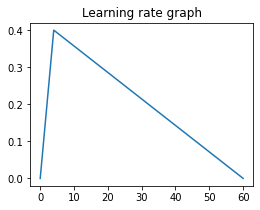

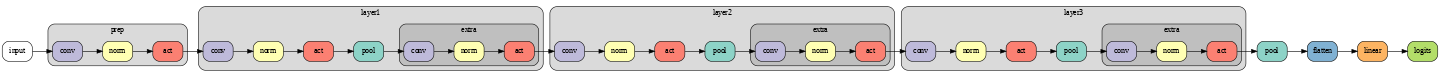

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       8.5994       2.2066       0.2321       1.0799       2.2133       0.1738       8.5994
           2       0.2000       1.8397       1.8007       0.3913       0.1364       2.4688       0.3108      10.4390
           3       0.3000       1.8441       1.4819       0.5046       0.1388       2.2455       0.3618      12.2832
           4       0.4000       1.8556       1.3092       0.5648       0.1359       1.3178       0.5647      14.1388
           5       0.3929       1.8444       1.1350       0.6271       0.1361       1.3167       0.5752      15.9832
           6       0.3857       1.8482       1.0062       0.6700       0.1376       1.0380       0.6629      17.8314
           7       0.3786       1.8474       0.9212       0.6901       0.1365       1.0265       0.6734      19.6788
           8       0.3714       1.8623       0.8458       0.7233

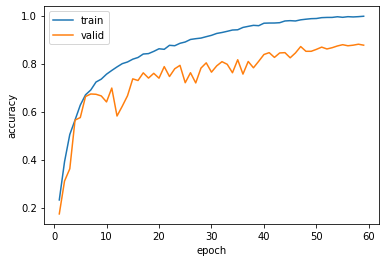

Evaluation and plotting done after 91.55876553500002 seconds


In [27]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 60], [0, 0.4, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer2', 'layer3'),
    residual_layers=()
)
batch_size = 512
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

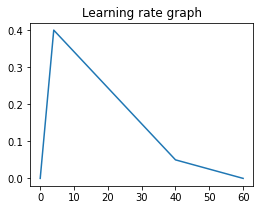

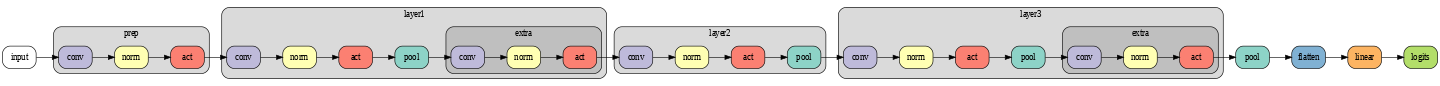

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.8486       2.1904       0.2354       0.1344       2.2313       0.1621       1.8486
           2       0.2000       1.8212       1.7669       0.4172       0.1323       1.8426       0.4054       3.6698
           3       0.3000       1.8184       1.4075       0.5303       0.1338       1.5004       0.5141       5.4882
           4       0.4000       1.8105       1.2055       0.5965       0.1343       1.4746       0.5255       7.2987
           5       0.3903       1.8112       1.0458       0.6591       0.1351       1.1103       0.6354       9.1099
           6       0.3806       1.8244       0.9068       0.7067       0.1341       1.1480       0.6435      10.9343
           7       0.3708       1.8207       0.8339       0.7333       0.1334       0.8868       0.7053      12.7550
           8       0.3611       1.8283       0.7563       0.7543

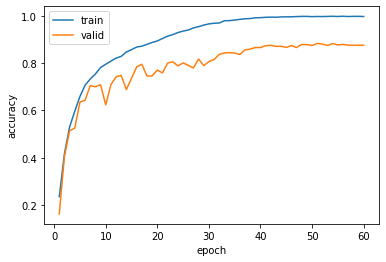

Evaluation and plotting done after 83.1011820800004 seconds


In [28]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 40, 60], [0, 0.4, 0.05, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 512
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

### Use CELU?

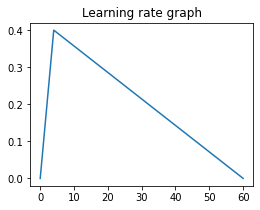

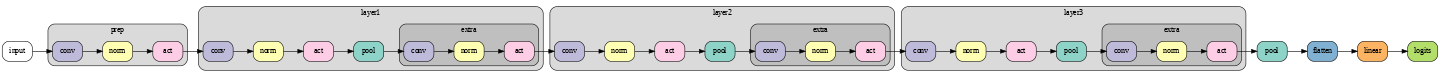

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0332       2.1997       0.2340       0.1500       2.1785       0.1746       2.0332
           2       0.2000       1.9784       1.7810       0.3975       0.1465       2.6331       0.3108       4.0115
           3       0.3000       1.9799       1.5196       0.4922       0.1475       1.8475       0.4139       5.9914
           4       0.4000       1.9813       1.3022       0.5669       0.1484       1.6384       0.4782       7.9728
           5       0.3929       1.9865       1.1551       0.6183       0.1511       1.2950       0.5853       9.9593
           6       0.3857       1.9895       1.0292       0.6596       0.1478       0.9509       0.6819      11.9488
           7       0.3786       1.9810       0.9506       0.6836       0.1483       1.2502       0.6079      13.9298
           8       0.3714       1.9926       0.8638       0.7178

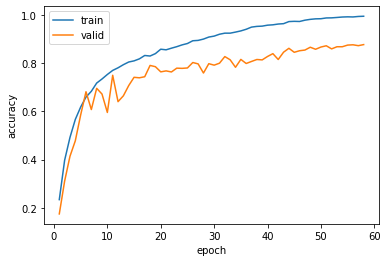

Evaluation and plotting done after 92.67152352999983 seconds


In [29]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 60], [0, 0.4, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_celu,
    extra_layers=('layer1', 'layer2', 'layer3'),
    residual_layers=()
)
batch_size = 512
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

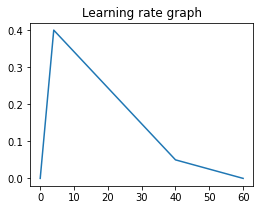

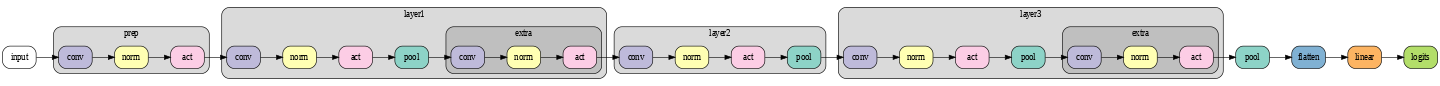

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.8805       2.1840       0.2391       0.1340       2.2220       0.1584       1.8805
           2       0.2000       1.7947       1.7681       0.4086       0.1329       2.1640       0.3371       3.6752
           3       0.3000       1.7989       1.4626       0.5025       0.1333       1.6286       0.4717       5.4741
           4       0.4000       1.8005       1.2041       0.5977       0.1355       1.1304       0.6314       7.2746
           5       0.3903       1.8004       1.0732       0.6464       0.1338       1.1075       0.6346       9.0750
           6       0.3806       1.8054       0.9289       0.6991       0.1359       1.0105       0.6758      10.8804
           7       0.3708       1.8172       0.8444       0.7270       0.1373       0.8469       0.7280      12.6976
           8       0.3611       1.8205       0.7720       0.7512

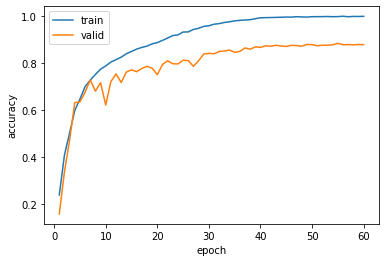

Evaluation and plotting done after 82.90598731099999 seconds


In [30]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 40, 60], [0, 0.4, 0.05, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_celu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 512
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

### Use larger batch size?

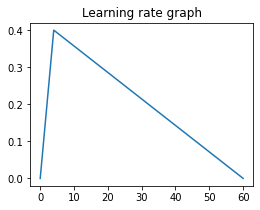

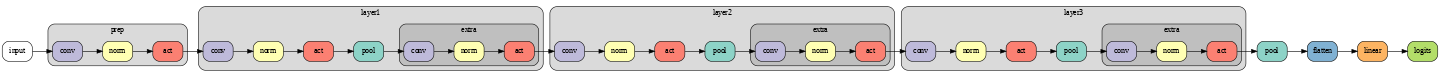

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000      12.0890       2.2485       0.2071       0.5783       2.2870       0.1342      12.0890
           2       0.2000       1.9197       1.9126       0.3651       0.1421       1.9487       0.3379      14.0088
           3       0.3000       1.9379       1.6629       0.4385       0.1431       2.8785       0.3088      15.9466
           4       0.4000       1.9190       1.4554       0.5150       0.1459       1.7986       0.4386      17.8656
           5       0.3929       1.9312       1.2718       0.5766       0.1471       1.2510       0.5808      19.7968
           6       0.3857       1.9350       1.1007       0.6377       0.1437       1.1843       0.6112      21.7318
           7       0.3786       1.9235       1.0154       0.6587       0.1442       1.0287       0.6584      23.6554
           8       0.3714       1.9291       0.9226       0.6976

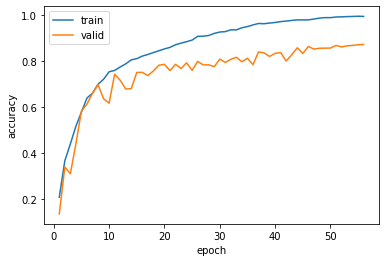

Evaluation and plotting done after 91.74277320000056 seconds


In [31]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 60], [0, 0.4, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer2', 'layer3'),
    residual_layers=()
)
batch_size = 768
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

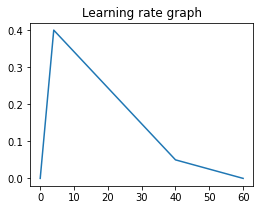

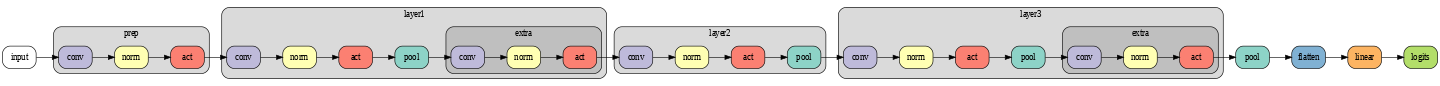

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.8563       2.2328       0.2125       0.1329       2.2718       0.1750       1.8563
           2       0.2000       1.7764       1.8934       0.3801       0.1329       1.8530       0.3577       3.6327
           3       0.3000       1.7740       1.6319       0.4528       0.1318       2.2799       0.3440       5.4067
           4       0.4000       1.7729       1.3703       0.5390       0.1312       1.7367       0.4612       7.1796
           5       0.3903       1.7741       1.1990       0.6072       0.1365       1.1750       0.6180       8.9537
           6       0.3806       1.7861       1.0427       0.6514       0.1340       1.0759       0.6487      10.7398
           7       0.3708       1.7924       0.9268       0.6978       0.1320       0.9755       0.6766      12.5323
           8       0.3611       1.7881       0.8543       0.7238

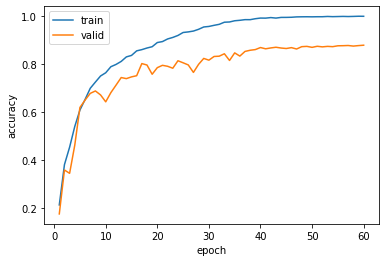

Evaluation and plotting done after 82.01163290499971 seconds


In [32]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 40, 60], [0, 0.4, 0.05, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 768
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

### Use smaller batch size?

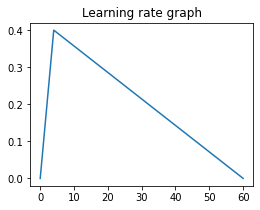

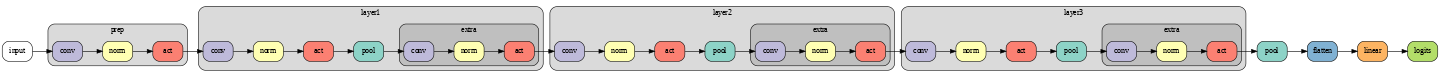

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       3.6448       1.9586       0.3213       0.2921       1.8850       0.3945       3.6448
           2       0.2000       2.0791       1.4470       0.5176       0.1519       1.6886       0.4616       5.7239
           3       0.3000       2.0858       1.2274       0.5871       0.1530       1.5176       0.5396       7.8098
           4       0.4000       2.0757       1.1369       0.6255       0.1502       1.0646       0.6419       9.8855
           5       0.3929       2.0736       1.0460       0.6562       0.1494       1.0589       0.6605      11.9591
           6       0.3857       2.0786       0.9526       0.6851       0.1512       1.1804       0.6120      14.0377
           7       0.3786       2.0853       0.9119       0.7007       0.1521       1.1942       0.6237      16.1230
           8       0.3714       2.0909       0.8693       0.7200

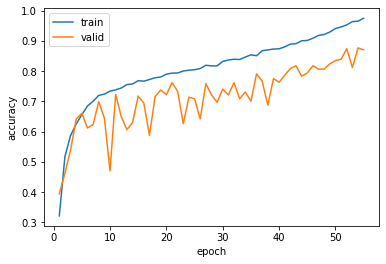

Evaluation and plotting done after 91.1690042500004 seconds


In [33]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 60], [0, 0.4, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer2', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

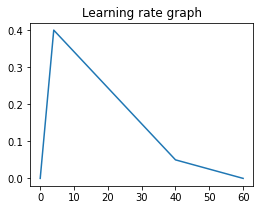

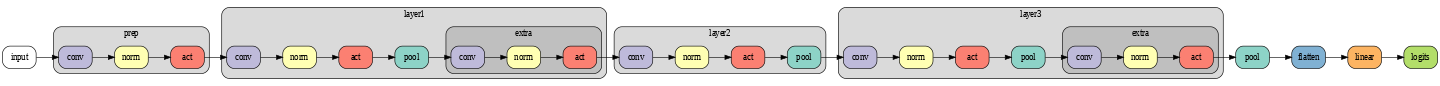

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.9605       1.9270       0.3338       0.1383       2.3528       0.3254       1.9605
           2       0.2000       1.8935       1.3419       0.5569       0.1393       1.4871       0.5053       3.8540
           3       0.3000       1.8943       1.1560       0.6145       0.1385       1.1506       0.6269       5.7483
           4       0.4000       1.8949       1.0330       0.6576       0.1394       1.0964       0.6285       7.6432
           5       0.3903       1.9022       0.9582       0.6842       0.1395       1.1563       0.6087       9.5454
           6       0.3806       1.9092       0.8616       0.7183       0.1499       0.9417       0.6884      11.4546
           7       0.3708       1.9177       0.8080       0.7328       0.1391       0.9603       0.6799      13.3724
           8       0.3611       1.9117       0.7686       0.7501

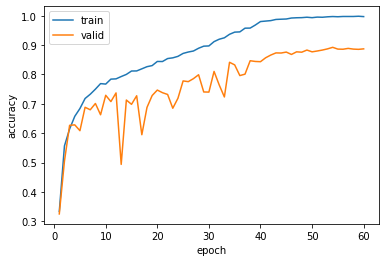

Evaluation and plotting done after 81.79817772699971 seconds


In [34]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 40, 60], [0, 0.4, 0.05, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

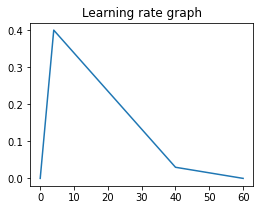

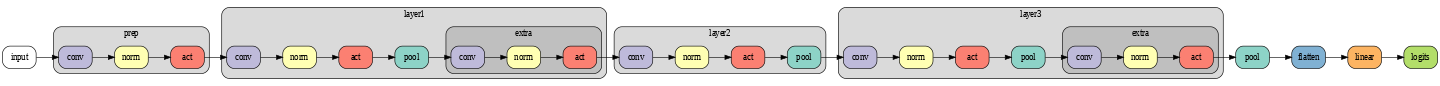

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.9575       1.9281       0.3328       0.1435       2.3649       0.3387       1.9575
           2       0.2000       1.9121       1.3308       0.5619       0.1403       1.6430       0.4527       3.8696
           3       0.3000       1.8992       1.1418       0.6169       0.1401       1.0724       0.6516       5.7688
           4       0.4000       1.9029       1.0289       0.6616       0.1394       1.1817       0.6039       7.6718
           5       0.3897       1.9061       0.9412       0.6913       0.1385       1.1947       0.6196       9.5778
           6       0.3794       1.9119       0.8560       0.7220       0.1382       0.9385       0.6952      11.4898
           7       0.3692       1.9121       0.8071       0.7341       0.1448       0.8974       0.7001      13.4019
           8       0.3589       1.9209       0.7585       0.7529

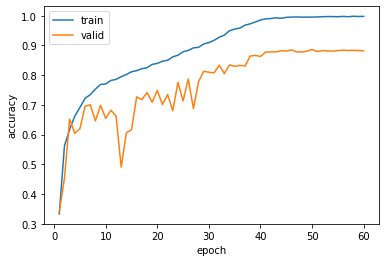

Evaluation and plotting done after 84.67700806100038 seconds


In [35]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 40, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

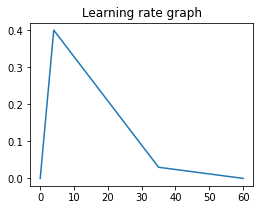

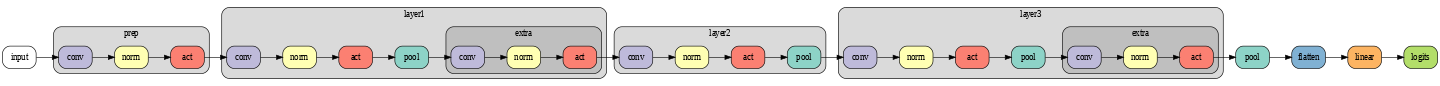

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.9584       1.9258       0.3339       0.1405       3.1702       0.2664       1.9584
           2       0.2000       1.9112       1.3372       0.5588       0.1388       1.7242       0.4402       3.8696
           3       0.3000       1.8979       1.1391       0.6216       0.1380       1.0384       0.6657       5.7675
           4       0.4000       1.9034       1.0242       0.6612       0.1394       1.1584       0.6132       7.6709
           5       0.3881       1.9070       0.9551       0.6847       0.1398       1.1908       0.6043       9.5779
           6       0.3761       1.9070       0.8614       0.7222       0.1383       1.0372       0.6601      11.4849
           7       0.3642       1.9080       0.8045       0.7385       0.1441       0.8648       0.7203      13.3929
           8       0.3523       1.9212       0.7621       0.7520

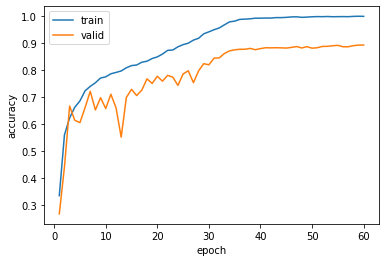

Evaluation and plotting done after 82.31282105599985 seconds


In [36]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

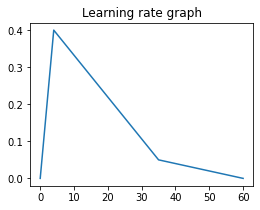

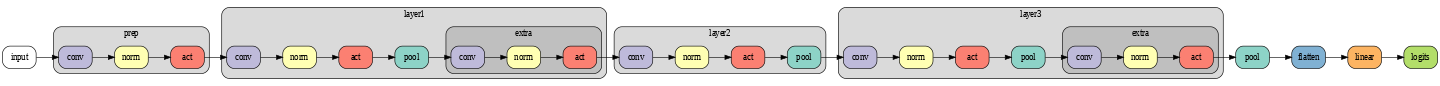

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.9746       1.9269       0.3351       0.1389       2.2327       0.3343       1.9746
           2       0.2000       1.9053       1.3422       0.5551       0.1405       1.5367       0.5073       3.8799
           3       0.3000       1.9106       1.1444       0.6200       0.1405       1.0936       0.6399       5.7905
           4       0.4000       1.9067       1.0248       0.6655       0.1410       1.1943       0.5934       7.6971
           5       0.3887       1.9036       0.9505       0.6866       0.1391       1.1712       0.6059       9.6007
           6       0.3774       1.9082       0.8613       0.7204       0.1401       0.9103       0.6993      11.5089
           7       0.3661       1.9136       0.8171       0.7320       0.1393       0.8562       0.7251      13.4226
           8       0.3548       1.9116       0.7678       0.7465

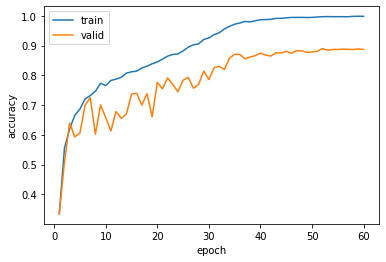

Evaluation and plotting done after 83.17614665200017 seconds


In [37]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.05, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

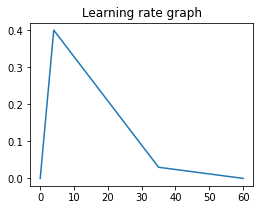

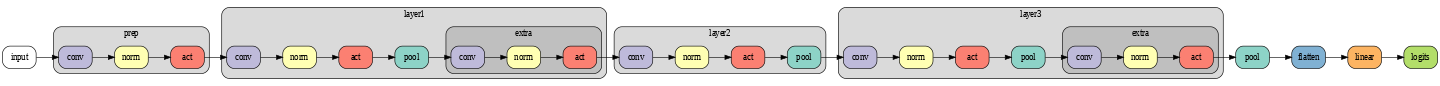

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.9687       1.9495       0.3216       0.1381       2.5450       0.3181       1.9687
           2       0.2000       1.8984       1.4221       0.5255       0.1395       1.3832       0.5360       3.8672
           3       0.3000       1.9119       1.2118       0.5956       0.1415       1.2712       0.5901       5.7791
           4       0.4000       1.9139       1.1036       0.6384       0.1391       1.3975       0.5428       7.6930
           5       0.3881       1.9067       1.0373       0.6598       0.1392       1.1263       0.6366       9.5997
           6       0.3761       1.9045       0.9317       0.6968       0.1382       1.0194       0.6572      11.5042
           7       0.3642       1.9049       0.8940       0.6989       0.1390       0.9593       0.6831      13.4091
           8       0.3523       1.9114       0.8425       0.7232

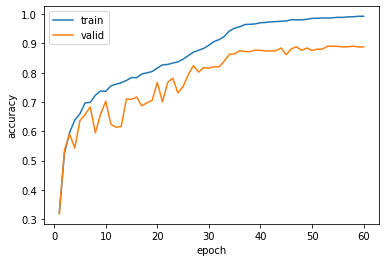

Evaluation and plotting done after 82.41394717099956 seconds


In [38]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

### Moving max-pool layers?

In [46]:
# Basic building blocks
def conv_bn_relu(c_in, c_out, pool=True, **kw):
    # conv -> pool -> norm -> act
    if pool:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'pool': nn.MaxPool2d(2),
          'norm': batch_norm(c_out, **kw),
          'act': nn.ReLU(True)
      }
    else:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'act': nn.ReLU(True)
      }

# Compound all building blocks into a single network
def DAWN_net(channels, base_block, extra_layers, residual_layers, **kw):
    # x + relu(res2(res1(x)))
    residual = lambda c, **kw: {
        'in': Identity(),
        'res1': base_block(c, c, **kw),
        'res2': base_block(c, c, **kw),
        'add': (Add(), ['in', 'res2/act'])
    }

    n = {
        'input': (None, []),
        'prep': base_block(3, channels['prep'], pool=False, **kw),
        'layer1': base_block(channels['prep'], channels['layer1'], **kw),
        'layer2': base_block(channels['layer1'], channels['layer2'], **kw),
        'layer3': base_block(channels['layer2'], channels['layer3'], **kw),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(0.125), # tuned hyperparameter
    }

    # apply ResNet connections or make it deeper
    for layer in residual_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = base_block(channels[layer], channels[layer], pool=False, **kw)
    
    draw(build_graph(n))
    return Network(n).to(device).half()

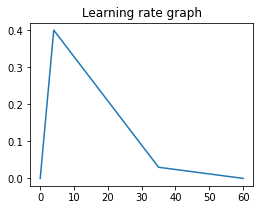

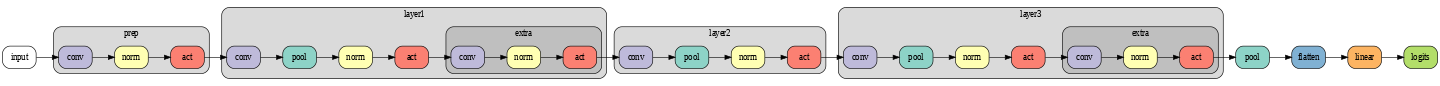

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.7245       1.9820       0.3034       0.1192       1.9223       0.3779       1.7245
           2       0.2000       1.6656       1.4280       0.5242       0.1228       1.2582       0.5942       3.3901
           3       0.3000       1.6804       1.1854       0.6079       0.1234       1.4291       0.5404       5.0705
           4       0.4000       1.6743       1.0732       0.6470       0.1210       1.1805       0.6200       6.7447
           5       0.3881       1.6757       0.9977       0.6710       0.1211       1.0430       0.6613       8.4204
           6       0.3761       1.6705       0.8992       0.7099       0.1231       1.1413       0.6330      10.0909
           7       0.3642       1.6775       0.8511       0.7190       0.1215       0.9091       0.6973      11.7684
           8       0.3523       1.6819       0.8025       0.7369

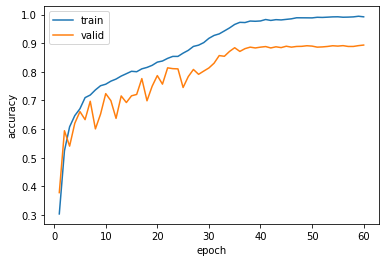

Evaluation and plotting done after 82.61582552800064 seconds


In [47]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

In [48]:
# Basic building blocks
def conv_bn_relu(c_in, c_out, pool=True, **kw):
    # conv -> norm -> pool -> act
    if pool:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'pool': nn.MaxPool2d(2),
          'act': nn.ReLU(True)
      }
    else:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'act': nn.ReLU(True)
      }

# Compound all building blocks into a single network
def DAWN_net(channels, base_block, extra_layers, residual_layers, **kw):
    # x + relu(res2(res1(x)))
    residual = lambda c, **kw: {
        'in': Identity(),
        'res1': base_block(c, c, **kw),
        'res2': base_block(c, c, **kw),
        'add': (Add(), ['in', 'res2/act'])
    }

    n = {
        'input': (None, []),
        'prep': base_block(3, channels['prep'], pool=False, **kw),
        'layer1': base_block(channels['prep'], channels['layer1'], **kw),
        'layer2': base_block(channels['layer1'], channels['layer2'], **kw),
        'layer3': base_block(channels['layer2'], channels['layer3'], **kw),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(0.125), # tuned hyperparameter
    }

    # apply ResNet connections or make it deeper
    for layer in residual_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = base_block(channels[layer], channels[layer], pool=False, **kw)
    
    draw(build_graph(n))
    return Network(n).to(device).half()

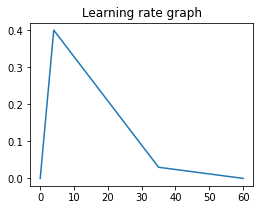

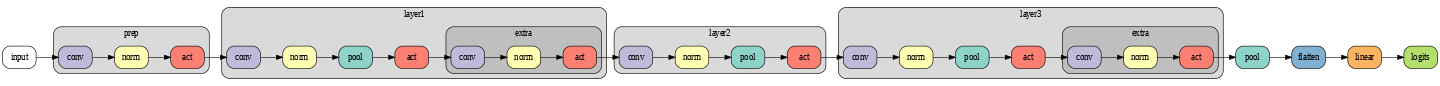

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.8943       1.9460       0.3220       0.1306       2.3446       0.3440       1.8943
           2       0.2000       1.8378       1.4200       0.5286       0.1322       1.4090       0.5267       3.7321
           3       0.3000       1.8454       1.2144       0.5965       0.1333       1.1218       0.6285       5.5775
           4       0.4000       1.8351       1.1025       0.6415       0.1355       1.1425       0.6196       7.4126
           5       0.3881       1.8472       1.0280       0.6598       0.1367       1.0632       0.6593       9.2599
           6       0.3761       1.8494       0.9274       0.6979       0.1319       0.9426       0.6884      11.1092
           7       0.3642       1.8442       0.8881       0.7055       0.1322       0.9291       0.6956      12.9534
           8       0.3523       1.8531       0.8469       0.7262

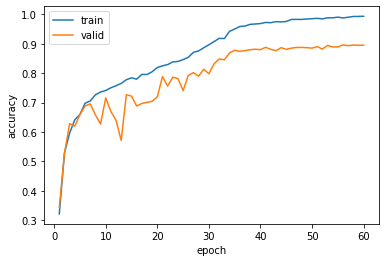

Evaluation and plotting done after 81.52853625399985 seconds


In [49]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

### Frozen BatchNorm?

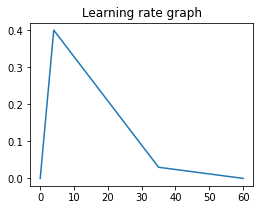

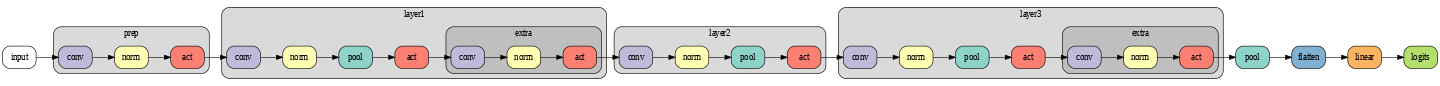

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.8727       1.9481       0.3225       0.1267       2.3816       0.3314       1.8727
           2       0.2000       1.8204       1.4103       0.5307       0.1326       1.3857       0.5420       3.6932
           3       0.3000       1.8355       1.2165       0.5966       0.1330       1.3910       0.5715       5.5287
           4       0.4000       1.8237       1.1258       0.6325       0.1329       1.4240       0.5477       7.3524
           5       0.3881       1.8215       1.0602       0.6537       0.1324       1.0812       0.6475       9.1739
           6       0.3761       1.8264       0.9505       0.6891       0.1346       1.1978       0.6023      11.0003
           7       0.3642       1.8267       0.9187       0.6922       0.1340       1.0017       0.6661      12.8270
           8       0.3523       1.8282       0.8617       0.7164

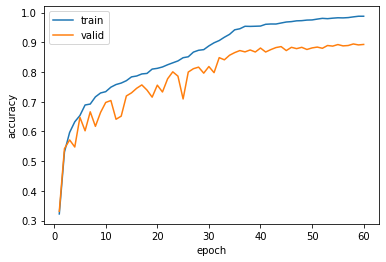

Evaluation and plotting done after 83.63819317200068 seconds


In [64]:
batch_norm = partial(BatchNorm, weight_freeze=True)

set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=conv_bn_relu,
    extra_layers=('layer1', 'layer3'),
    residual_layers=()
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])

model, summary = train_and_evaluate(model, lr_schedule, train_set_x, valid_set, test_set, batch_size=batch_size, num_workers=0)

In [65]:
model

Network(
  (prep_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (prep_norm): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prep_act): ReLU(inplace=True)
  (layer1_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1_norm): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1_act): ReLU(inplace=True)
  (layer1_extra_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1_extra_norm): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1_extra_act): ReLU(inplace=True)
  (layer2_conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer2_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2_pool)